In [17]:
import numpy as np
"""1.資料處理"""
with open('/content/drive/MyDrive/機器學習/Weather txt.txt', 'r') as file:
  data = file.read()
data = data.split('\n')[4:]
for i in range(len(data)):
  data[i] = data[i].split(',')
del data[0][0]
data_re = data[0][0][1:]
data[0][0] = data_re
del data[-1]
data_re = data[-1][-1][:-1]
data[-1][-1] = data_re
for weido in data:
  for i in range(len(weido)):
    weido[i] = float(weido[i])

# 這一步完成後，我們就有了最原始的溫度空間分佈資料
temp_grid = np.array(data).reshape(120, 67)

print("成功將資料重塑為 120x67 的網格！")
print("網格維度:", temp_grid.shape)
print("-" * 30)


# 根據作業說明，計算每個格點的經緯度
# 左下角經度 120.00, 緯度 21.88，每個格點間隔 0.03 度
longitudes = 120.00 + np.arange(67) * 0.03
latitudes = 21.88 + np.arange(120) * 0.03

# 準備兩個空列表，用來分別存放迴歸和分類的資料
regression_data = []
classification_data = []

# 遍歷整個 120x67 的網格
for w in range(120):  # w 代表緯度索引 (0-119)
    for j in range(67):  # j 代表經度索引 (0-66)

        # 取得該點的經緯度和溫度
        lon = longitudes[j]
        lat = latitudes[w]
        temp = temp_grid[w, j]

        # --- 處理分類資料 ---
        # 無論溫度是否有效，都加入分類資料集
        is_valid = 1.0 if temp != -999.0 else 0.0
        classification_data.append([lon, lat, is_valid])

        # --- 處理迴歸資料 ---
        # 只有在溫度有效時，才加入迴歸資料集
        if temp != -999.0:
            regression_data.append([lon, lat, temp])

# 將 Python 列表轉換為 NumPy Array，這是機器學習框架最喜歡的格式
data_reg_np = np.array(regression_data)
data_cla_np = np.array(classification_data)

print("成功建立機器學習資料集！")
print("\n--- 迴歸資料集 (前5筆) ---")
print(data_reg_np[:5])
print("迴歸資料集維度 (樣本數, 特徵數):", data_reg_np.shape)

print("\n--- 分類資料集 (前5筆) ---")
print(data_cla_np[:5])
print("分類資料集維度 (樣本數, 特徵數):", data_cla_np.shape)

成功將資料重塑為 120x67 的網格！
網格維度: (120, 67)
------------------------------
成功建立機器學習資料集！

--- 迴歸資料集 (前5筆) ---
[[120.84  21.94  28.1 ]
 [120.72  21.97  28.6 ]
 [120.75  21.97  28.6 ]
 [120.78  21.97  27.8 ]
 [120.81  21.97  26.5 ]]
迴歸資料集維度 (樣本數, 特徵數): (3495, 3)

--- 分類資料集 (前5筆) ---
[[120.    21.88   0.  ]
 [120.03  21.88   0.  ]
 [120.06  21.88   0.  ]
 [120.09  21.88   0.  ]
 [120.12  21.88   0.  ]]
分類資料集維度 (樣本數, 特徵數): (8040, 3)


In [18]:
"""2. 迴歸模型"""
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(data_reg_np[:, :2], data_reg_np[:, 2], test_size=0.2, random_state=42)
X_cla_train, X_cla_test, y_cla_train, y_cla_test = train_test_split(data_cla_np[:, :2], data_cla_np[:, 2], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_reg_train = scaler.fit_transform(X_reg_train)
y_reg_train = y_reg_train.reshape(-1, 1)
X_reg_test = scaler.transform(X_reg_test)
y_reg_test = y_reg_test.reshape(-1, 1)

X_cla_train = scaler.fit_transform(X_cla_train)
y_cla_train = y_cla_train.reshape(-1,1)
X_cla_test = scaler.transform(X_cla_test)
y_cla_tset = y_cla_test.reshape(-1,1)

# Functional API (A bit more flexible)
inputs = keras.Input(shape=(2,), name="input_coordinates")
x = layers.Dense(64, activation="relu", name="hidden_layer_1")(inputs)
x = layers.Dense(64, activation="relu", name="hidden_layer_2")(x)
x = layers.Dense(64, activation="relu", name="hidden_layer_3")(x)
outputs = layers.Dense(1, name="output_temperature")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)
print("--- 模型結構 ---")
model.summary()

model.fit(X_reg_train, y_reg_train, batch_size=20, epochs=50, verbose=2)
model.evaluate(X_reg_test, y_reg_test, batch_size=20, verbose=2)

--- 模型結構 ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_coordinates (InputLayer)  │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_temperature (Dense)      │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
140/140 - 1s - 9ms/step - accuracy: 0.0000e+00 - loss: 66.5095
Epoch 2/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 17.9466
Epoch 3/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 14.8550
Epoch 4/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 12.7818
Epoch 5/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 12.0092
Epoch 6/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 11.6959
Epoch 7/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 11.9512
Epoch 8/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 11.0839
Epoch 9/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 10.6473
Epoch 10/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 10.3496
Epoch 11/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 10.2069
Epoch 12/50
140/140 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 9.7865
Epoch 13/50
140/140 - 1s - 4ms/step - accuracy: 0.0000e+00 - loss: 9.7744
Epoch 14/50
140/140 - 0s - 3ms/step 

[8.163992881774902, 0.0]

In [19]:
"""3.回歸模型訓練"""
history = model.fit(
    X_reg_train,  # 使用標準化後的資料
    y_reg_train,
    batch_size=32,
    epochs=20,       # 可以增加 Epochs 來讓模型學習更久
    verbose=2,
  )

Epoch 1/20
88/88 - 1s - 14ms/step - accuracy: 0.0000e+00 - loss: 7.7364
Epoch 2/20
88/88 - 0s - 4ms/step - accuracy: 0.0000e+00 - loss: 7.7683
Epoch 3/20
88/88 - 1s - 7ms/step - accuracy: 0.0000e+00 - loss: 7.8406
Epoch 4/20
88/88 - 1s - 6ms/step - accuracy: 0.0000e+00 - loss: 7.8165
Epoch 5/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.7555
Epoch 6/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6109
Epoch 7/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.7904
Epoch 8/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6150
Epoch 9/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6700
Epoch 10/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6469
Epoch 11/20
88/88 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 7.7187
Epoch 12/20
88/88 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 7.6629
Epoch 13/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6541
Epoch 14/20
88/88 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 7.6027


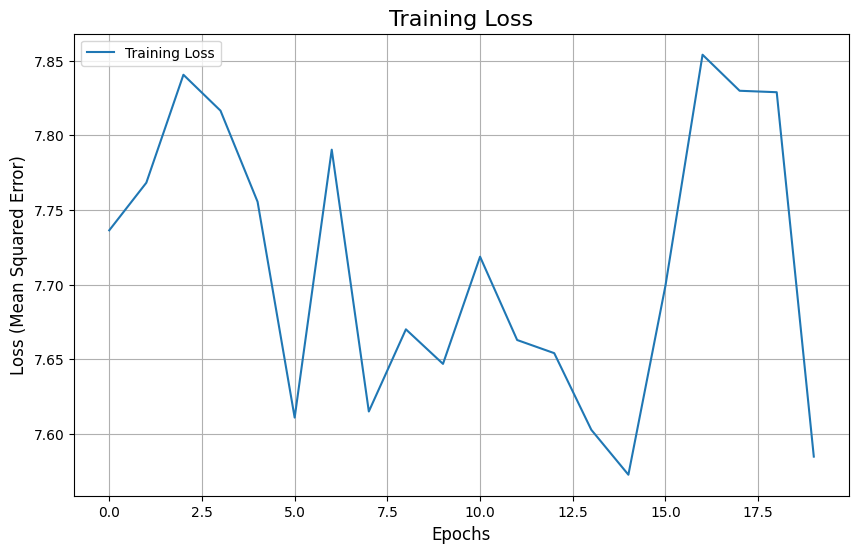

In [20]:
import matplotlib.pyplot as plt

# --- 從 history 物件中提取數據 ---
# history.history 是一個字典，包含了 'loss', 'val_loss', 'mean_absolute_error', 'val_mean_absolute_error' 等鍵
train_loss = history.history['loss']

# 獲取 epoch 的總數
epochs = range(1, len(train_loss) + 1)

# --- 開始繪圖 ---
plt.figure(figsize=(10, 6))

# 畫出訓練集 loss 的曲線
plt.plot(train_loss, label='Training Loss') # 'bo-' 表示藍色圓點和實線


# --- 美化圖表 ---
plt.title('Training Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend() # 顯示圖例
plt.grid(True) # 顯示網格

# 顯示圖表
plt.show()

In [21]:
"""4.回歸模型評估"""
print("\n--- 評估模型在測試集上的表現 ---")
model.evaluate(X_reg_test, y_reg_test, batch_size=32, verbose=2)


--- 評估模型在測試集上的表現 ---
22/22 - 0s - 19ms/step - accuracy: 0.0000e+00 - loss: 7.6870


[7.6870317459106445, 0.0]

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


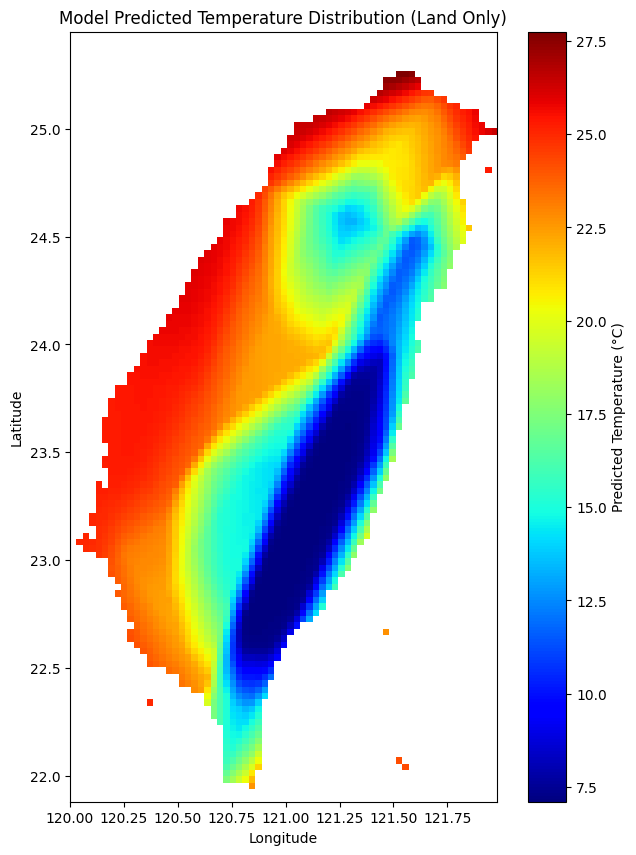

In [22]:
import numpy as np
import matplotlib.pyplot as plt
"""5. 回歸預測圖"""
# --- 假設您已經完成了以下步驟 ---
# 1. 建立了 scaler 並用 X_train 訓練過
# 2. 建立了 model 並用 X_train_scaled 訓練過
# 3. 建立了 temp_grid (120x67 的原始溫度 NumPy array)
# ------------------------------------


# 1. 建立一個覆蓋整個台灣的完整網格座標 (這一步不變)
lons = 120.00 + np.arange(67) * 0.03
lats = 21.88 + np.arange(120) * 0.03
grid_lon, grid_lat = np.meshgrid(lons, lats)
grid_coords = np.vstack([grid_lon.ravel(), grid_lat.ravel()]).T

# 2. 使用之前 fit 過的 scaler 來轉換整個網格 (這一步不變)
grid_coords_scaled = scaler.transform(grid_coords)

# 3. 讓模型對整個網格進行預測 (這一步不變)
predicted_temps_flat = model.predict(grid_coords_scaled)
predicted_grid = predicted_temps_flat.reshape(120, 67)


# --- 【關鍵修正】 4. 建立並應用遮罩 ---

# 根據原始的 temp_grid，找出所有是海的地方 (-999.0)
# sea_mask 會是一個布林 (boolean) 陣列，海的地方是 True，陸地是 False
sea_mask = (temp_grid == -999.0)

# 將我們預測出來的溫度網格中，所有對應到海的位置，都設為 np.nan
predicted_grid[sea_mask] = np.nan


# --- 5. 繪製被遮罩過的熱力圖 ---
plt.figure(figsize=(8, 10))

# imshow 會自動忽略 np.nan 的值，所以只會畫出陸地
plt.imshow(predicted_grid, cmap='jet', origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()])

plt.colorbar(label='Predicted Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Model Predicted Temperature Distribution (Land Only)')
plt.show()

In [23]:
"""6.建立分類模型"""

inputs_cla = keras.Input(shape=(2,), name="input_coordinates")

# 隱藏層 (可以嘗試不同的架構)
x = layers.Dense(64, activation="relu", name="hidden_layer_1")(inputs_cla)
x = layers.Dense(64, activation="relu", name="hidden_layer_2")(x)
x = layers.Dense(64, activation="relu", name="hidden_layer_3")(x)
# 【關鍵差異 1】 輸出層
# 必須使用 sigmoid 激活函數，將輸出壓縮到 0~1 之間，代表「是陸地的機率」
outputs_cla = layers.Dense(1, activation="sigmoid", name="output_probability")(x)

model_cla = keras.Model(inputs=inputs_cla, outputs=outputs_cla)


# 【關鍵差異 2】 編譯模型
model_cla.compile(
    # 使用二元分類最經典的損失函數
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.03),
    # 我們最關心的是「準確率 (Accuracy)」
    metrics=["accuracy"]
)

print("--- 分類模型結構 ---")
model_cla.summary()

--- 分類模型結構 ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_coordinates (InputLayer)  │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probability (Dense)      │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
"""7.訓練分類模型"""
print("\n--- 開始訓練分類模型 ---")

history_cla = model_cla.fit(
    X_cla_train,
    y_cla_train,
    batch_size=32,
    epochs=20, # 分類任務通常收斂更快
    verbose=2,
)

# --- 4. 評估模型 ---
print("\n--- 評估分類模型在測試集上的表現 ---")
loss, accuracy = model_cla.evaluate(X_cla_test, y_cla_test, verbose=2)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


--- 開始訓練分類模型 ---
Epoch 1/20
201/201 - 1s - 6ms/step - accuracy: 0.5928 - loss: 0.6163
Epoch 2/20
201/201 - 0s - 2ms/step - accuracy: 0.8403 - loss: 0.4547
Epoch 3/20
201/201 - 0s - 2ms/step - accuracy: 0.9338 - loss: 0.2999
Epoch 4/20
201/201 - 0s - 2ms/step - accuracy: 0.9538 - loss: 0.2021
Epoch 5/20
201/201 - 0s - 2ms/step - accuracy: 0.9607 - loss: 0.1541
Epoch 6/20
201/201 - 0s - 2ms/step - accuracy: 0.9611 - loss: 0.1304
Epoch 7/20
201/201 - 0s - 2ms/step - accuracy: 0.9611 - loss: 0.1163
Epoch 8/20
201/201 - 0s - 2ms/step - accuracy: 0.9622 - loss: 0.1086
Epoch 9/20
201/201 - 0s - 2ms/step - accuracy: 0.9621 - loss: 0.1037
Epoch 10/20
201/201 - 1s - 3ms/step - accuracy: 0.9641 - loss: 0.0990
Epoch 11/20
201/201 - 1s - 3ms/step - accuracy: 0.9622 - loss: 0.0962
Epoch 12/20
201/201 - 1s - 3ms/step - accuracy: 0.9655 - loss: 0.0954
Epoch 13/20
201/201 - 1s - 3ms/step - accuracy: 0.9667 - loss: 0.0898
Epoch 14/20
201/201 - 1s - 3ms/step - accuracy: 0.9618 - loss: 0.0929
Epoch 15/20

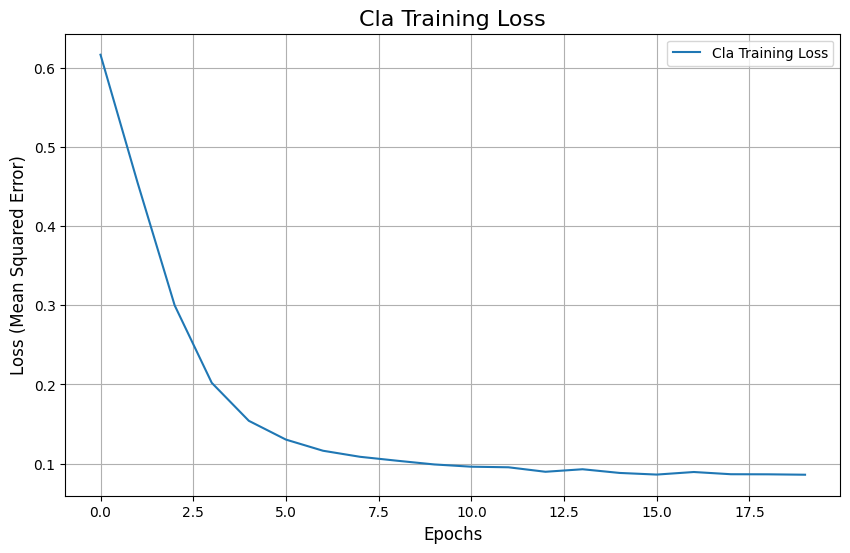

In [25]:
import matplotlib.pyplot as plt

# --- 從 history 物件中提取數據 ---
# history.history 是一個字典，包含了 'loss', 'val_loss', 'mean_absolute_error', 'val_mean_absolute_error' 等鍵
train_loss_cla = history_cla.history['loss']

# 獲取 epoch 的總數
epochs = range(1, len(train_loss_cla) + 1)

# --- 開始繪圖 ---
plt.figure(figsize=(10, 6))

# 畫出訓練集 loss 的曲線
plt.plot(train_loss_cla, label='Cla Training Loss') # 'bo-' 表示藍色圓點和實線


# --- 美化圖表 ---
plt.title('Cla Training Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend() # 顯示圖例
plt.grid(True) # 顯示網格

# 顯示圖表
plt.show()

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


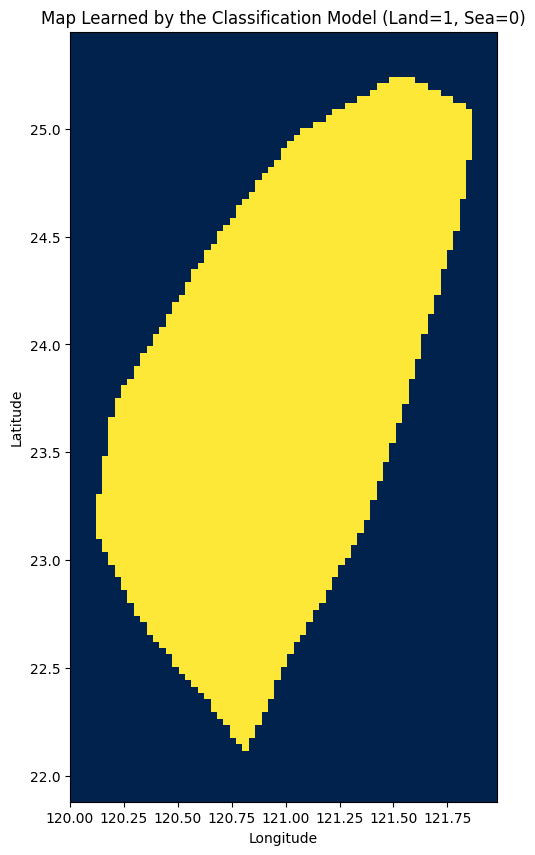

In [26]:
# --- 假設您已經完成了以下步驟 ---
# 1. 建立了 scaler_cla 並用 X_cla_train 訓練過
# 2. 建立了 model_cla 並用 X_cla_train_scaled 訓練過
# ------------------------------------

# 1. 建立一個覆蓋整個台灣的完整網格座標 (與迴歸時相同)
lons = 120.00 + np.arange(67) * 0.03
lats = 21.88 + np.arange(120) * 0.03
grid_lon, grid_lat = np.meshgrid(lons, lats)
grid_coords = np.vstack([grid_lon.ravel(), grid_lat.ravel()]).T

# 2. (重要) 使用您訓練分類模型時的 scaler_cla 來轉換整個網格
grid_coords_scaled = scaler.transform(grid_coords)

# 3. 讓模型對整個網格進行預測
# 模型的輸出是機率值 (例如 0.01, 0.98 等)
predicted_probs_flat = model_cla.predict(grid_coords_scaled)

# 4. 【關鍵步驟】 將機率轉換為分類 (0 或 1)
# 我們以 0.5 為閾值，大於 0.5 就判斷為陸地 (1)，否則為海洋 (0)
predicted_classes_flat = (predicted_probs_flat > 0.5).astype(int)

# 5. 將預測結果重塑回 120x67 的網格
predicted_map = predicted_classes_flat.reshape(120, 67)

# 6. 繪製模型學到的地圖
plt.figure(figsize=(8, 10))
# cmap='cividis' 是一個黑白對比較強的色盤，適合畫 0/1 地圖
plt.imshow(predicted_map, cmap='cividis', origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map Learned by the Classification Model (Land=1, Sea=0)')
plt.show()

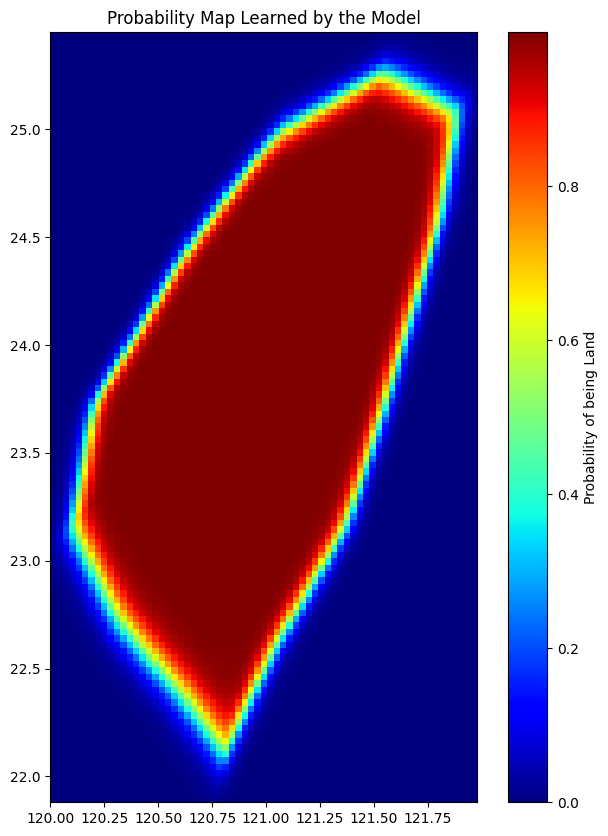

In [27]:
# (接續您之前的預測程式碼)
# predicted_probs_flat = model_cla.predict(grid_coords_scaled)
probability_map = predicted_probs_flat.reshape(120, 67)

plt.figure(figsize=(8, 10))
plt.imshow(probability_map, cmap='jet', origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()])
plt.colorbar(label='Probability of being Land')
plt.title('Probability Map Learned by the Model')
plt.show()

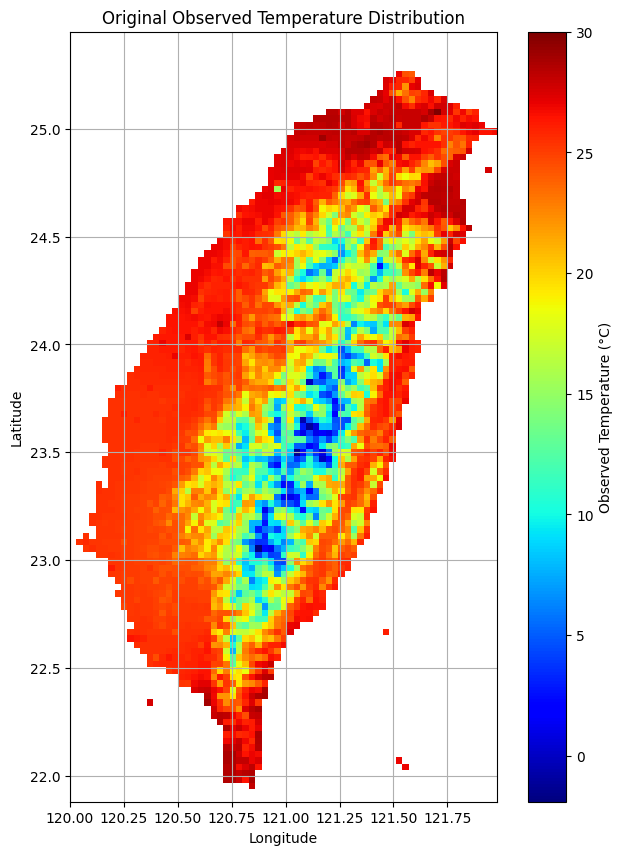

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- 假設 temp_grid (120, 67 的原始溫度網格) 已經存在 ---
# 如果不存在，請先執行之前的資料處理程式碼

# --- 1. 建立一個用於繪圖的副本，並處理無效值 ---
# 我們將 -999.0 換成 np.nan，這樣 matplotlib 就會忽略海洋，不會扭曲顏色尺度
plot_grid = temp_grid.copy() # 建立副本，避免修改到原始資料
plot_grid[plot_grid == -999.0] = np.nan


# --- 2. 建立對應的經緯度座標軸 ---
# 這將用於正確標示圖表的 x 和 y 軸
lons = 120.00 + np.arange(67) * 0.03
lats = 21.88 + np.arange(120) * 0.03


# --- 3. 繪製熱力圖 (Heatmap) ---
plt.figure(figsize=(8, 10))

# 使用 imshow 繪圖
# extent=[lons.min(), lons.max(), lats.min(), lats.max()] 是關鍵，它會將座標軸設定為真實的經緯度
plt.imshow(plot_grid, cmap='jet', origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()])

# --- 4. 美化圖表 ---
plt.colorbar(label='Observed Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original Observed Temperature Distribution')
plt.grid(True)
plt.show()